In [1]:
import numpy as np
from sklearn.datasets import load_breast_cancer
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

class AdaBoostSAMME:
    def __init__(self, n_estimators=50):
        self.n_estimators = n_estimators
        self.estimators = []
        self.estimator_weights = []
        self.estimator_errors = []

    def fit(self, X, y):
        n_samples = X.shape[0]
        sample_weights = np.full(n_samples, 1 / n_samples)
        classes = np.unique(y)

        for _ in range(self.n_estimators):
            # 创建一个弱分类器（这里假设使用决策树作为弱分类器）
            estimator = DecisionTreeClassifier(max_depth=1)
            estimator.fit(X, y, sample_weight=sample_weights)

            # 计算弱分类器的错误率
            y_pred = estimator.predict(X)
            incorrect = y_pred != y
            estimator_error = np.sum(sample_weights * incorrect) / np.sum(sample_weights)

            # 计算弱分类器的权重
            estimator_weight = np.log((1 - estimator_error) / estimator_error) + np.log(len(classes) - 1)

            # 更新样本权重
            sample_weights *= np.exp(estimator_weight * incorrect)

            # 归一化样本权重
            sample_weights /= np.sum(sample_weights)

            # 保存弱分类器和其权重
            self.estimators.append(estimator)
            self.estimator_weights.append(estimator_weight)
            self.estimator_errors.append(estimator_error)

    def predict(self, X):
        n_samples = X.shape[0]
        classes = len(self.estimators[0].classes_)
        predictions = np.zeros((n_samples, classes))

        for estimator, weight in zip(self.estimators, self.estimator_weights):
            y_pred = estimator.predict(X)
            for i in range(n_samples):
                predictions[i, y_pred[i]] += weight

        # 对预测结果进行投票
        y_pred = np.argmax(predictions, axis=1)
        return y_pred

# 自定义交叉验证
def custom_cross_val_score(estimator, X, y, cv=5):
    n_samples = X.shape[0]
    fold_size = n_samples // cv
    scores = []

    for i in range(cv):
        start = i * fold_size
        end = (i + 1) * fold_size

        X_train = np.concatenate((X[:start], X[end:]), axis=0)
        y_train = np.concatenate((y[:start], y[end:]), axis=0)
        X_test = X[start:end]
        y_test = y[start:end]

        estimator.fit(X_train, y_train)
        y_pred = estimator.predict(X_test)
        accuracy = np.mean(y_pred == y_test)
        scores.append(accuracy)

    return scores

# 加载乳腺癌数据集
cancer = load_breast_cancer()
X, y = cancer.data, cancer.target

# 创建AdaBoost-SAMME分类器
clf = AdaBoostSAMME(n_estimators=52)

# 进行自定义交叉验证
custom_scores = custom_cross_val_score(clf, X, y, cv=10)

# 打印每折交叉验证的准确率
for i, score in enumerate(custom_scores):
    print(f"Fold {i+1}: {score}")

# 打印平均准确率
print("平均准确率:", np.mean(custom_scores))


Fold 1: 0.9285714285714286
Fold 2: 0.9821428571428571
Fold 3: 0.9821428571428571
Fold 4: 1.0
Fold 5: 1.0
Fold 6: 0.9821428571428571
Fold 7: 1.0
Fold 8: 1.0
Fold 9: 1.0
Fold 10: 1.0
平均准确率: 0.9875


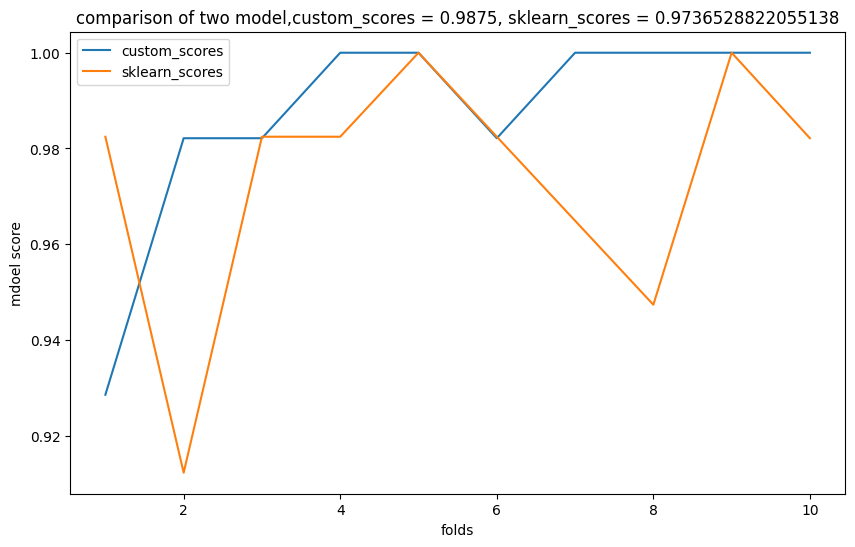

In [4]:
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
import matplotlib.pyplot as plt

sk_model = AdaBoostClassifier(learning_rate=1, n_estimators=52, random_state=10,algorithm='SAMME')

# 交叉验证
scores = cross_val_score(sk_model, X, y, cv=10,n_jobs=-1)

# 可视化对比上面的custom_scores和sklearn的scores
plt.figure(figsize=(10, 6))
plt.plot(range(1, 11), custom_scores, label='custom_scores')
plt.plot(range(1, 11), scores, label='sklearn_scores')

plt.legend()
plt.title(f'comparison of two model,custom_scores = {np.mean(custom_scores)}, sklearn_scores = {np.mean(scores)}')
plt.xlabel('folds')
plt.ylabel('mdoel score')
plt.show()

# 出现了手写的AdaBoost-SAMME分类器的准确率比sklearn的AdaBoostClassifier分类器的准确率高的情况，
